This is a language analysis notebook.

In [42]:
def lang_confidence_score(word_counts: dict[str, float], language_words_with_frequency: dict[str, float]) -> float:
    if(len(word_counts) == 0):
        return 1
    number_of_words = 0
    for val in word_counts.items():
        number_of_words += val[1]
    deviation = 0
    for word in word_counts:
        if(word not in word_counts or word not in language_words_with_frequency): 
            # Dictionary miss - we impose the most severe penalty.
            deviation += 1
        else:
            # Word found in dictionary - we impose penalty based on difference of frequency in text and frequency in dictionary.
            deviation += (word_counts[word] / number_of_words - language_words_with_frequency[word])**2
    return 1 - deviation / len(word_counts)


In [43]:
import wordfreq 

def create_lang_dict(size, language):
    words = wordfreq.top_n_list(language, size, wordlist='best')
    d = {w: wordfreq.word_frequency(w, language) for w in set(words)}
    return d


en_dict = create_lang_dict(1000, 'en')
fr_dict = create_lang_dict(1000, 'fr')
de_dict = create_lang_dict(1000, 'de')

Create large article dictionary

In [44]:
import json
import os
from pathlib import Path

p = Path('./word-counts.json')

if(p.exists()):
    p.unlink()

%run wikiscraper.py --count-words Ash

with open('./word-counts.json', 'r') as file:
    large_article = json.load(file)



Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.



Take article with low fr and de scores

In [45]:
p = Path('./word-counts.json')

lowest_score = 1

for i in range(0, 1):

    if(p.exists()):
        p.unlink()

    %run wikiscraper.py --count-words 'List_of_Pokémon_by_weight'

    with open('./word-counts.json', 'r') as file:
        potential_article = json.load(file)
    
    if(len(potential_article) >= 20):
        score = lang_confidence_score(potential_article, en_dict)
        if(score < lowest_score):
            lowest_score = score
            interesting_article = potential_article

# Verify that the score is low

print(lang_confidence_score(interesting_article, en_dict))
print(lang_confidence_score(interesting_article, fr_dict))
print(lang_confidence_score(interesting_article, de_dict))


Output below was generated using an article originally published on https://bulbapedia.bulbagarden.net/wiki.
It is licensed under BY-NC-SA.

0.08422293361862976
0.02141214745263298
0.017843842776039676


Create english, french and german dictionaries based on classic literature

In [46]:
def text_to_dict(book_path):
    with open(book_path, 'r') as file:
        text_content = file.read()
    text_content = ''.join(list(map(lambda c: c.lower() if (c.isalpha() or c == ' ') else ' ', text_content)))
    
    counter: dict[str, int] = {}
    for word in text_content.split():
        counter[word] = counter.get(word, 0) + 1
    return counter


In [47]:
frankenstein_dict = text_to_dict('./frankenstein.txt')
faust_dict = text_to_dict('./faust.txt')
candide_dict = text_to_dict('./candide.txt')

Create DataFrame with all 15 combinations

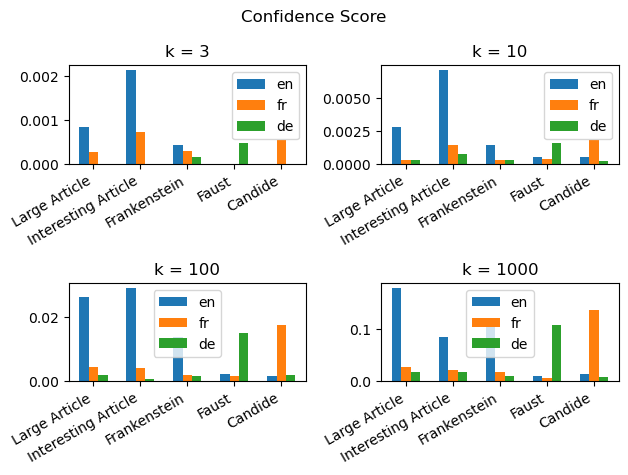

In [48]:
import numpy as np
import matplotlib.pyplot as plt

texts = [large_article, interesting_article, frankenstein_dict, faust_dict, candide_dict]
labels = ['Large Article', 'Interesting Article', 'Frankenstein', 'Faust', 'Candide']
languages = ['en', 'fr', 'de']

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for idx, k in enumerate([3, 10, 100, 1000]):
    matrix = np.empty([len(texts), len(languages)])
    for i, t in enumerate(texts):
        for j, l in enumerate(languages):
            matrix[i][j] = lang_confidence_score(t, create_lang_dict(k, l))

    x = np.arange(len(texts))
    width = 0.2
    ax = axes[idx]
        
    for j, l in enumerate(languages):
        ax.bar(x + j*width, matrix[:, j], width, label=l)
        
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels, rotation = 30, ha='right')
    ax.set_title(f'k = {k}')
    ax.legend()

fig.suptitle('Confidence Score')
plt.tight_layout()
plt.show()


Results:  
We can see that the proposed function is somewhat accurate in identifying the language of the wiki. 
For all considered k's (being the number of most common words fetched from the language's dictionary) texts score significantly higher with the dictionary of the language they are written in.
The way we define our confidence function implies that the score strictly increases as k increases. 
This is clearly confirmed by our examples, as all scores increase significantly with large k's.  

Even though the assigned scores are relatively low, the function succeeds at effectively identyfing the language of our text - surprisingly even for k as low as 10.

All three language dictionaries perform similarly despite the confidence function relying on the inflection of the words to correctly identify matches. 
However, German and Faust slightly lag behind with its assigned scores - this is possibly due to declation.

Despite the above, it is difficult to unambigiously state which language has the most word inflection - the results are simply too similar.



Finding an article with a low score was difficult. Scraping random articles proved to be ineffective, so my best guess was an article with a list of pokemon names.
Surprisingly, even though it consists largely of pokemon names (which of course are not in the english dictionary) it score for k=1000 is only around 2 times smaller than
the flagship article about Ash Ketchum, which consists of long paragraphs written in (mostly) conventional english.